### Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [1]:
from sklearn.linear_model    import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from xgboost                 import XGBRegressor

from sklearn.metrics         import mean_absolute_error , mean_squared_error 

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as ms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [24]:
bike_df = pd.read_csv('../data/bike_sharing_train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
bike_df.dtypes.value_counts()

int64      8
float64    3
object     1
dtype: int64

<AxesSubplot:xlabel='count', ylabel='Density'>

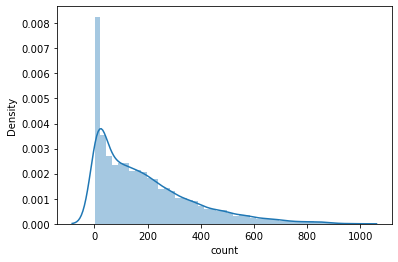

In [7]:
sns.distplot(bike_df['count'])

In [25]:
# datetime 타입변경 --> 년, 월, 일, 시
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [26]:
# 년, 월, 일 시 따로따로 가져와보기
bike_df.datetime.apply(lambda x : x.year)
bike_df.datetime.apply(lambda x : x.month)
bike_df.datetime.apply(lambda x : x.day)
bike_df.datetime.apply(lambda x : x.hour)

0         0
1         1
2         2
3         3
4         4
         ..
10881    19
10882    20
10883    21
10884    22
10885    23
Name: datetime, Length: 10886, dtype: int64

In [27]:
# 파생컬럼으로 추가
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)

bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [28]:
# 파생컬럼으로 추가했으니 필요없는 datetime 컬럼 삭제
bike_df.drop('datetime', axis=1, inplace=True)

In [31]:
# 평가지표 함수
def evaluation_rmsle(y, pred) :
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    error = (log_y - log_pred)**2
    return np.sqrt(np.mean(error))

def evaluation(y, pred) :
    mae   = mean_absolute_error(y, pred)
    mse   = mean_squared_error(y, pred)
    rmse  = np.sqrt(mean_squared_error(y, pred))
    rmsle = evaluation_rmsle(y, pred)
    print('MAE : {}, MSE : {}, RMSE : {}, RMSLE :{}'.format(mae, mse, rmse, rmsle))

In [33]:
# model selection
y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis=1, inplace=False)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=.2, random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 14), (2178, 14), (8708,), (2178,))

In [54]:
# LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)
evaluation(y_test, linear_pred)

# Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
evaluation(y_test, ridge_pred)

# Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
evaluation(y_test, lasso_pred)

MAE : 4.49370772202104e-13, MSE : 3.3603186231948554e-25, RMSE : 5.796825530576934e-13, RMSLE :5.0882506973027675e-14
MAE : 2.1378816550868157e-06, MSE : 1.0165014263521798e-11, RMSE : 3.1882619502672294e-06, RMSLE :1.9120384826493473e-07
MAE : 0.013685009711109681, MSE : 0.0004196622644695355, RMSE : 0.020485659971539495, RMSLE :0.0009930903881668494


In [56]:
# 정답과 예측된 값을 데이터프레임형태로 만들어주는 함수
def error_data(y_test, pred) :
    error_data_df = pd.DataFrame(y_test.values, columns=['target'])
    error_data_df['prediction'] = np.round(linear_pred)
    error_data_df['differ'] = np.abs(error_data_df['target'] - error_data_df['prediction'])
    display(error_data_df.sort_values('differ', ascending=False))

In [57]:
error_data(y_test, lasso_pred)

,target,prediction,differ
0,513,513.0,0.0
1454,118,118.0,0.0
1448,120,120.0,0.0
1449,220,220.0,0.0
1450,37,37.0,0.0
...,...,...,...
720,184,184.0,0.0
719,446,446.0,0.0
718,392,392.0,0.0
717,221,221.0,0.0


### 타겟의 대한 로그변환 --> 학습

<AxesSubplot:xlabel='count', ylabel='Density'>

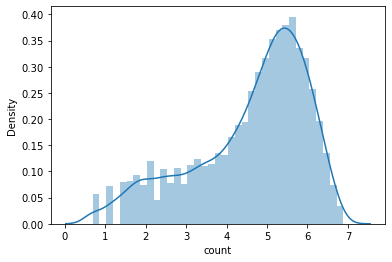

In [58]:
log_target = np.log1p(y_target)
sns.distplot(log_target)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x_features, log_target, test_size=.2, random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 14), (2178, 14), (8708,), (2178,))

In [62]:
# 로그변환을 했기 때문에 지수함수 np.exp(), exp2(), expm1() = exp()-1 사용해야함!
# LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)
evaluation(np.expm1(y_test), np.expm1(linear_pred))

# Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
evaluation(np.expm1(y_test), np.expm1(ridge_pred))

# Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
evaluation(np.expm1(y_test), np.expm1(lasso_pred))

MAE : 107.68976207017896, MSE : 155870.60215060634, RMSE : 394.804511309846, RMSLE :0.7088625245726065
MAE : 107.68930586323643, MSE : 155868.62001322836, RMSE : 394.80200102485344, RMSLE :0.7088625472869801
MAE : 117.76090728450714, MSE : 191781.65395759366, RMSE : 437.92882293541, RMSLE :0.7493489267734473


In [68]:
# 각 컬럼에 대한 회귀계수
linear_series = pd.Series(linear_model.coef_, index = x_features.columns)
ridge_series = pd.Series(ridge_model.coef_, index = x_features.columns)
lasso_seiries = pd.Series(lasso_model.coef_, index = x_features.columns)

<AxesSubplot:>

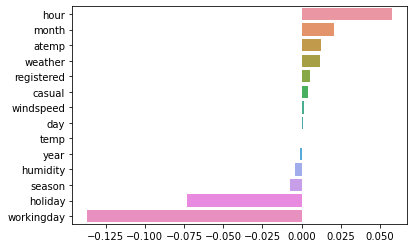

In [72]:
sns.barplot(x = linear_series.sort_values(ascending=False).values, y = linear_series.sort_values(ascending=False).index)

<AxesSubplot:>

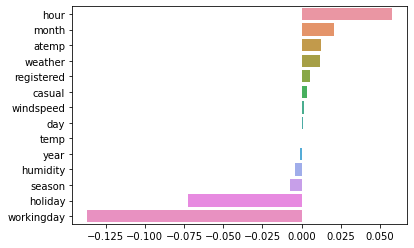

In [73]:
sns.barplot(x = ridge_series.sort_values(ascending=False).values, y = ridge_series.sort_values(ascending=False).index)

<AxesSubplot:>

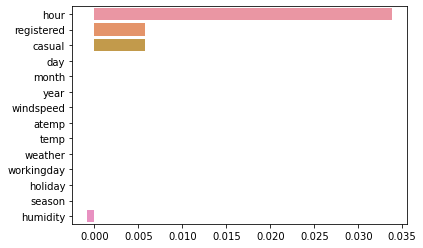

In [74]:
sns.barplot(x = lasso_seiries.sort_values(ascending=False).values, y = lasso_seiries.sort_values(ascending=False).index)